In [87]:
import numpy as np
from scipy.stats import multivariate_normal, norm
from utils import normalize
from numpy.linalg import cholesky, inv
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [98]:
def hug(T, B, x0, p, logpi, grad_log_pi):
    """
    Hug kernel.
    
    T : Float
        Integration time.
    B : Int
        Number of steps
    x0 : Numpy Array
         Initial point.
    p : Callable
        Symmetric proposal density for the velocity. Notice that in the paper this is called q.
        I have called it p to not create confusion with the constraint defining the manifold.
    """
    # Step size
    delta = int(T / B)
    p = multivariate_normal(mean=np.zeros(2), cov=np.eye(2))
    v0 = p.rvs()
    v = v0
    x = x0
    logu = np.log(np.random.rand())
    
    for b in range(B):
        x = x + delta*v/2  # Move ahead with current velocity by half step size
        g = grad_log_pi(x)
        ghat = g / np.linalg.norm(g)
        v = v - 2*(v @ ghat) * ghat
        x = x + delta*v/2
    
    if logu <= logpi(x) + p.logpdf(v) - logpi(x0) - p.logpdf(v0):
        return (x, v)
    else:
        return (x0, v0)

In [105]:
def hop(x, grad_log_pi, l, k):
    """
    Hop kernel.
    
    x : Numpy Array
        Starting point
    grad_log_pi : callable
                  Gradient of log target distribution. This is called g in the paper.
    l : Float
        Lambda
    k : Float
        Kappa
    """
    # μ, μ^2 and λ^2
    mu_sq = k * l
    mu = np.sqrt(mu_sq)
    l_sq = l**2
    
    # For MH step
    logu = np.log(np.random.rand())
    
    # Gradient, its norm and nornmalized gradient
    g = grad_log_pi(x)
    g_norm = np.linalg.norm(g)
    ghat = g / g_norm
    
    # B^{1/2}
    B_sqrt = (mu*np.eye(2) + (l - mu)*np.outer(ghat, ghat)) / np.sqrt(1 + g_norm**2)
    
    # Sample 
    v = multivariate_normal(mean=np.zeros(2), cov=np.eye(2)).rvs()
    
    # Proposal
    y = B_sqrt @ v
    
    # Accept-Reject
    logr = -0.5*((1/l_sq) - (1/mu_sq))*(((y - x) @ grad_log_pi(y))**2 - ((y - x) @ grad_log_pi(x))**2)
    if logu <= min(0, logr):
        # Accept
        x = y
    return x

In [112]:
mu = np.zeros(2)
Sigma = np.array([[1.0, 0.6], [0.6, 2.0]])
target = multivariate_normal(mu, Sigma)
p = multivariate_normal(np.zeros(2), np.eye(2))
grad_log_pi = lambda xy: - inv(Sigma) @ xy

T = 100
B = 100
N = 1000
l = 0.5
k = 0.5
x0 = target.rvs()
samples = x0

for i in range(N):
    x_hug, v = hug(T, B, x0, p, target.logpdf, grad_log_pi)
    x = hop(x_hug, grad_log_pi, l, k)
    samples = np.vstack((samples, x_hug))
    samples = np.vstack((samples, x))

# Diagnostics - Joint

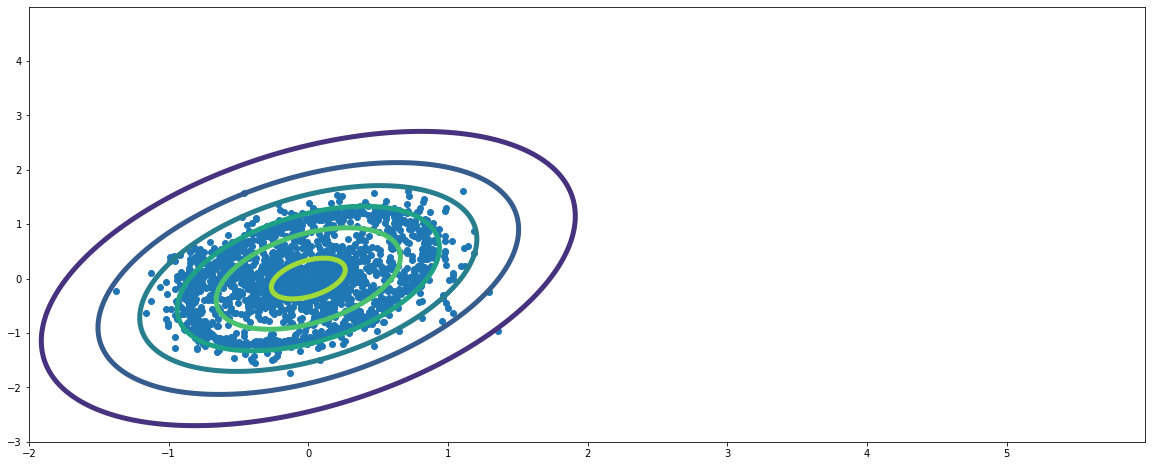

In [113]:
xlow = -2.0
xhigh = 6.0
ylow = -3.0
yhigh = 5.0
x, y = np.mgrid[xlow:xhigh:.01, ylow:yhigh:.01]
pos = np.dstack((x, y))

fig, ax = plt.subplots(figsize=(20, 8))
ax.contour(x, y, target.pdf(pos), linewidths=5) 
ax.scatter(*samples.T)
plt.show()

# Diagnostics - Marginals

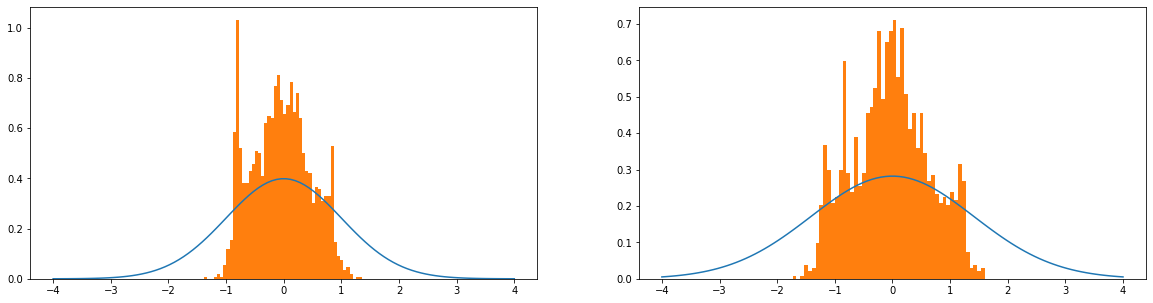

In [114]:
marginal_x = lambda x: norm(loc=mu[0], scale=np.sqrt(Sigma[0, 0])).pdf(x)
marginal_y = lambda y: norm(loc=mu[1], scale=np.sqrt(Sigma[1, 1])).pdf(y)

xx = np.linspace(-4, 4, num=100)

fig, ax = plt.subplots(ncols=2, figsize=(20, 5))
ax[0].plot(xx, marginal_x(xx))
_ = ax[0].hist(samples[:, 0], density=True, bins=50)
ax[1].plot(xx, marginal_y(xx))
_ = ax[1].hist(samples[:, 1], density=True, bins=50)


# Hugging a Contour

In [ ]:
x0 = target.rvs()
xlow = -2.0
xhigh = 6.0
ylow = -3.0
yhigh = 5.0
x, y = np.mgrid[xlow:xhigh:.01, ylow:yhigh:.01]
pos = np.dstack((x, y))

fig, ax = plt.subplots(figsize=(20, 8))
ax.contour(x, y, target.pdf(pos), linewidths=5, levels=target.pdf(x0)) 
plt.show()